<a href="https://colab.research.google.com/github/maianhtran2005/MachineLearning/blob/main/Tranthimaianh_Nhom5_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tải dữ liệu

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

Cách 1: Đọc dữ liệu liên kết với Google Drive chạy trên Google

Link hướng dẫn như sau: https://docs.google.com/document/d/1AfFKQqTaWJ-UKu-01vDoThKNTvw1vlZh/edit

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/ML/Demo/data/alzheimers_disease_data.csv')
# df.head()

Cách 2: Đọc dữ liệu từ Google Drive URL

In [ ]:

# Function to extract file ID from a Google Drive URL
def get_drive_id(url):
    match = re.search(r'file/d/([a-zA-Z0-9_-]+)', url)
    if match:
        return match.group(1)
    return None

dataset_url = 'https://drive.google.com/file/d/1O7_znBM5Tu8xGVzBSAbGP6mU03NZaY82/view?usp=sharing'
dataset_id = get_drive_id(dataset_url)

if dataset_id:
    # Construct a direct download link for the CSV file
    download_url = f'https://drive.google.com/uc?id={dataset_id}'

    try:
        df = pd.read_csv(download_url)
        print("Dataset loaded into df_from_url from Google Drive URL!")
        print(df.head()) # Display head to confirm
    except Exception as e:
        print(f"Error loading dataset from URL: {e}")
else:
    print("Could not extract dataset ID from the URL.")

Dataset loaded into df_from_url from Google Drive URL!
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4           18.454356          6.310461     0.795498  ...                 0   

   Behavioral

In [ ]:
df.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)
print(df.shape)

(2149, 33)


##Kỹ thuật đặc trưng

Đây là ma trận tương quan của các biến số có trong dữ liệu

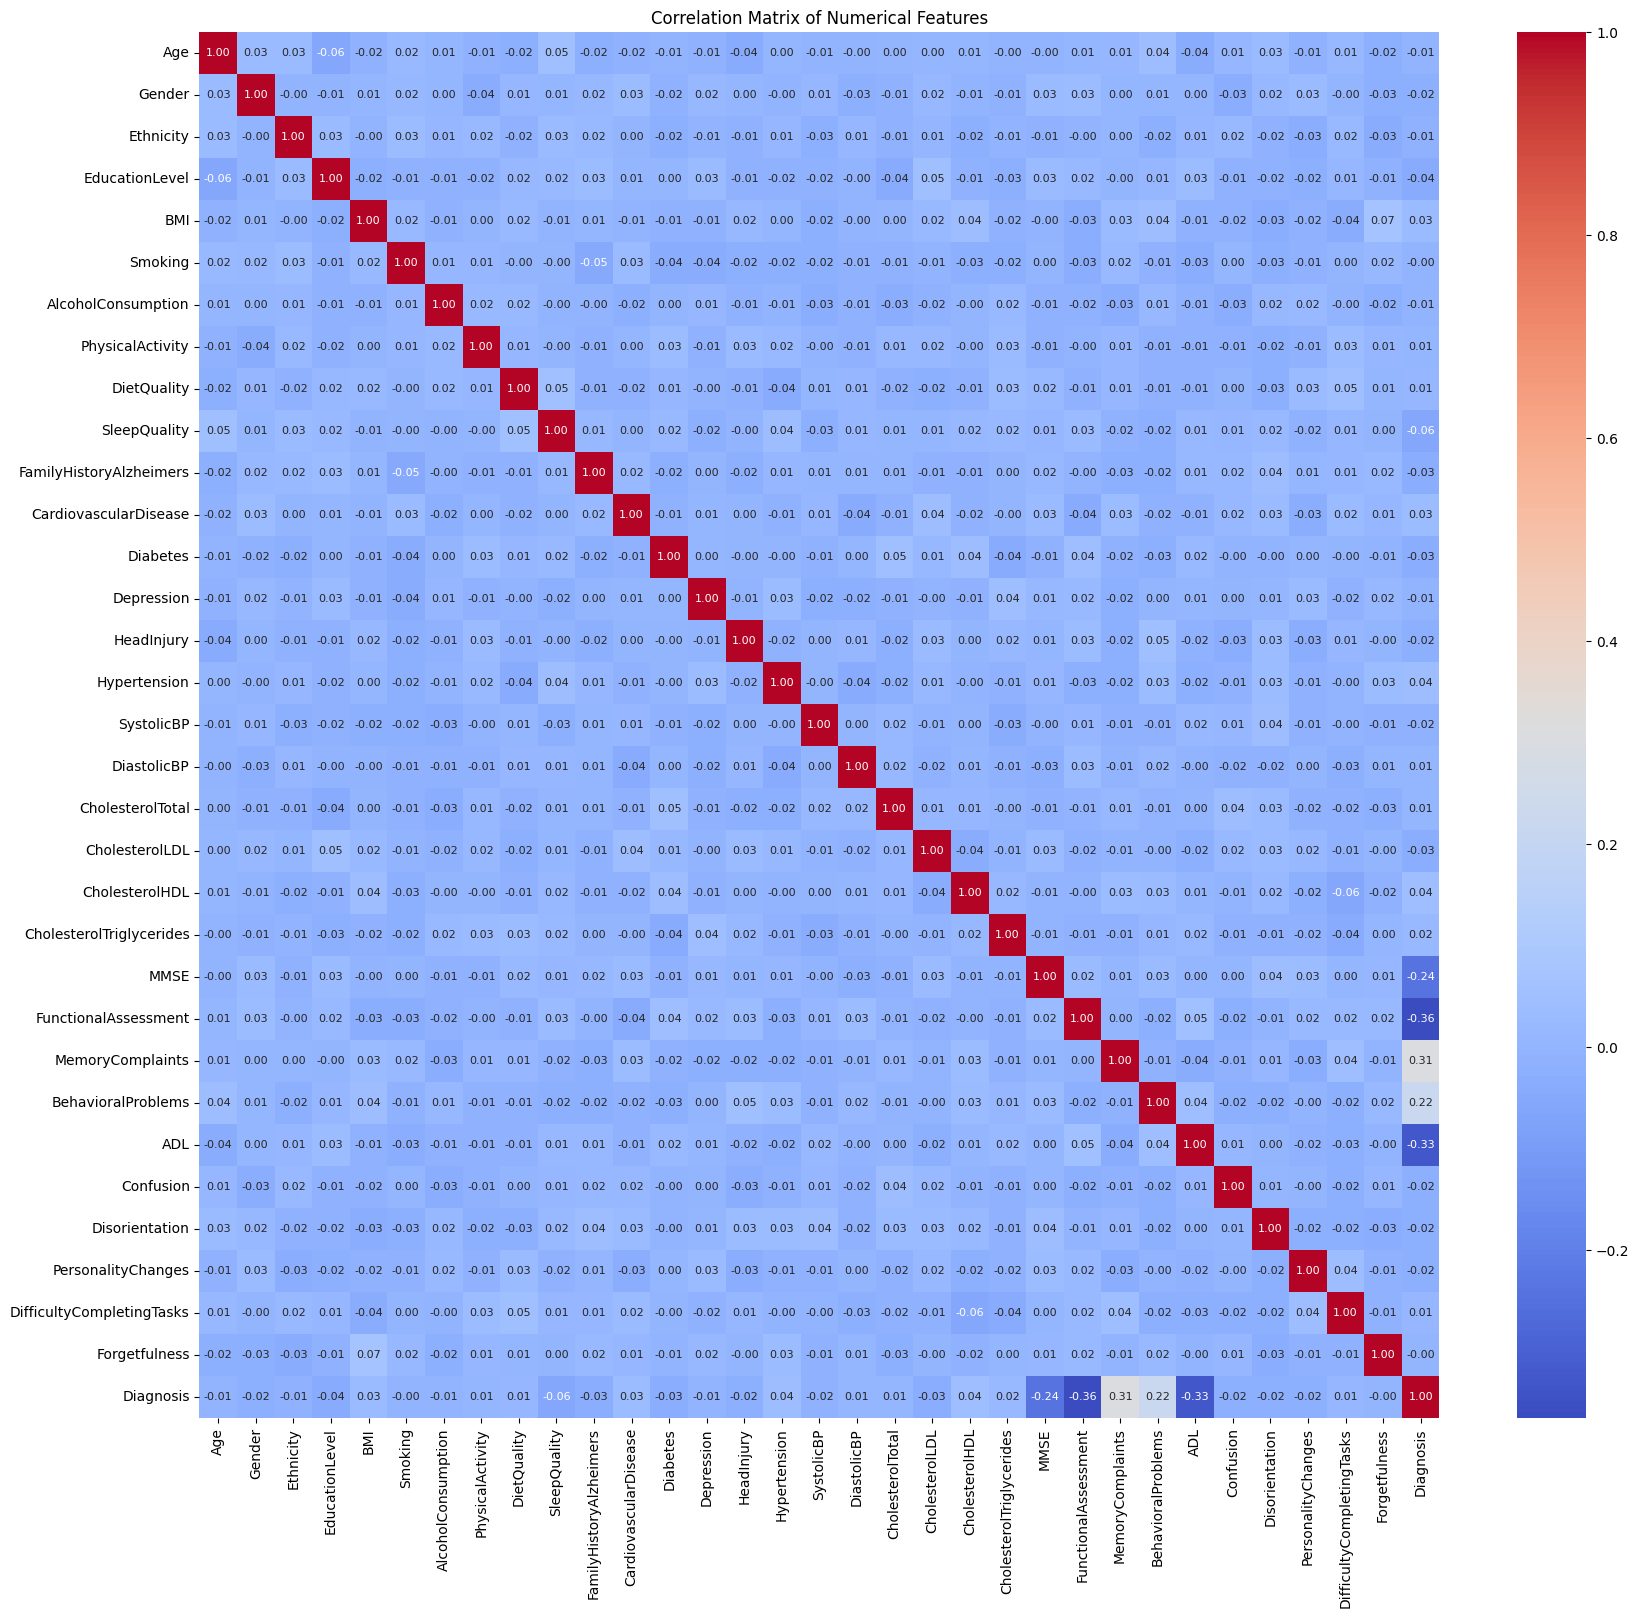

In [ ]:
numerical_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(20, 18))
sns.heatmap(
    df[numerical_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Dựa vào ma trận tương quan đã hiển thị ở bước trước, xác định được một số cặp đặc trưng dạng số có độ tương quan cao. Để giảm thiểu hiện tượng đa cộng tuyến (multicollinearity) nên loại bỏ một cột trong mỗi cặp tương quan cao, bao gồm: 'DiastolicBP' (tương quan cao với 'SystolicBP'), 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides' (tất cả đều tương quan cao với 'CholesterolTotal'), và 'FunctionalAssessment' (tương quan cao với 'ADL').

In [ ]:
columns_to_drop = ['DiastolicBP', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'FunctionalAssessment']
df1 = df.copy()
df1.drop(columns=[c for c in columns_to_drop if c in df.columns], inplace=True, errors='ignore')
df1.head()
print(f"DataFrame shape after dropping highly correlated columns: {df.shape}")

DataFrame shape after dropping highly correlated columns: (2149, 33)


Sau khi các đặc trưng dạng số đã được chuẩn hóa, thực hiện mã hóa one-hot (one-hot encode) cho cột 'Ethnicity', sử dụng hàm pd.get_dummies cho mục đích này, sau đó ghép nối các cột đã mã hóa vào DataFrame và loại bỏ cột 'Ethnicity' ban đầu.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
categorical_cols = [c for c in ['Ethnicity'] if c in df1.columns]
if categorical_cols:
    df1 = pd.get_dummies(df1, columns=categorical_cols, drop_first=False)

# đảm bảo 'Diagnosis' tồn tại và tách
if 'Diagnosis' not in df1.columns:
    raise ValueError("Cột 'Diagnosis' không có trong dataset.")
y = df1['Diagnosis'].copy()
X = df1.drop('Diagnosis', axis=1).copy()
#  Impute missing nếu có
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

#  Loại bỏ biến có phương sai rất nhỏ
vt = VarianceThreshold(threshold=1e-5)
vt.fit(X_imputed)
cols_kept = X_imputed.columns[vt.get_support()]
X_clean = X_imputed[cols_kept]

#  Chọn scaler: StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)

#1-Bài toán phân cụm

##Thuật toán phân cụm với dữ liệu được giảm chiều bằng PCA

Đoạn mã giảm chiều bộ dữ liệu bằng PCA (tối đa 25 thành phần), xác định số thành phần tối thiểu giữ lại ≥ 90 % phương sai, rồi trực quan hoá:

(i) đường tích lũy phương sai để chọn ngưỡng,

(ii) scatter PC1–PC2 tô màu theo nhãn Diagnosis để xem mức tách cụm,

(iii) biểu đồ cột tỷ lệ phương sai từng thành phần và

(iv) heatmap tương quan giữa n PC đầu và nhãn.

Cuối cùng, hàm trả về một DataFrame gồm n thành phần chính cùng cột nhãn cho các bước phân tích hoặc mô hình hoá tiếp theo.

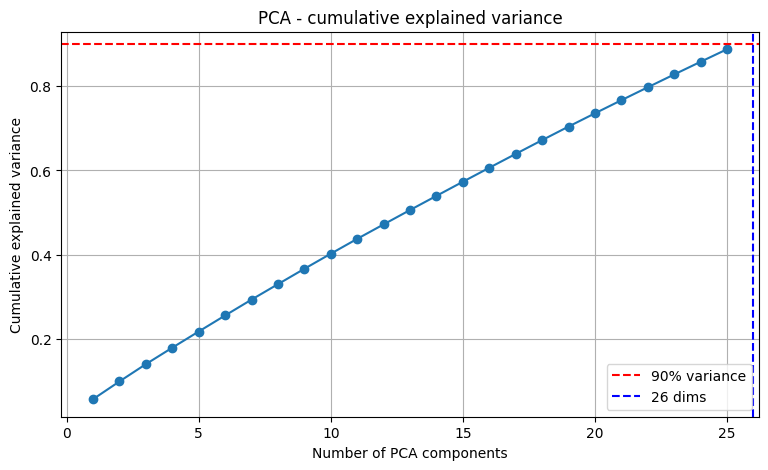

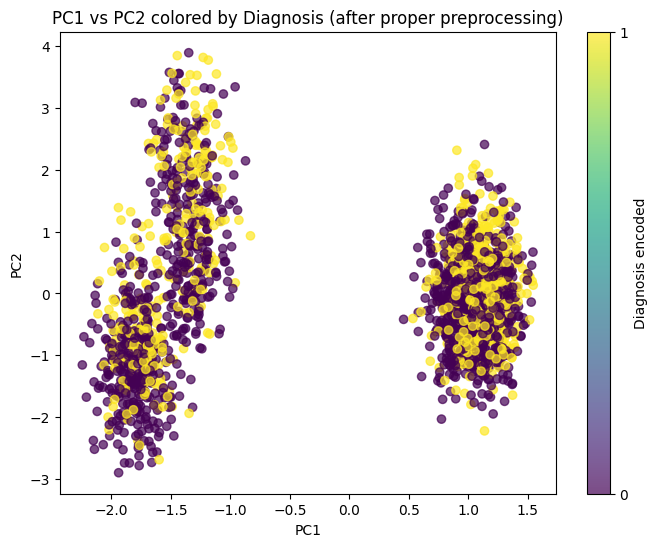

In [ ]:
max_components = min(25, X_scaled.shape[1])
pca = PCA(n_components=max_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
threshold_dim = int(np.searchsorted(cumulative_variance, 0.90) + 1)  # số chiều cần để đạt 90%

# Plot cumulative variance
plt.figure(figsize=(9,5))
plt.plot(range(1, max_components+1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance')
plt.axvline(x=threshold_dim, color='blue', linestyle='--', label=f'{threshold_dim} dims')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA - cumulative explained variance')
plt.legend()
plt.grid(True)
plt.show()

# Scatter PC1 vs PC2 (color by Diagnosis)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PC1 vs PC2 colored by Diagnosis (after proper preprocessing)')
plt.colorbar(sc, ticks=np.unique(y), label='Diagnosis encoded')
plt.show()

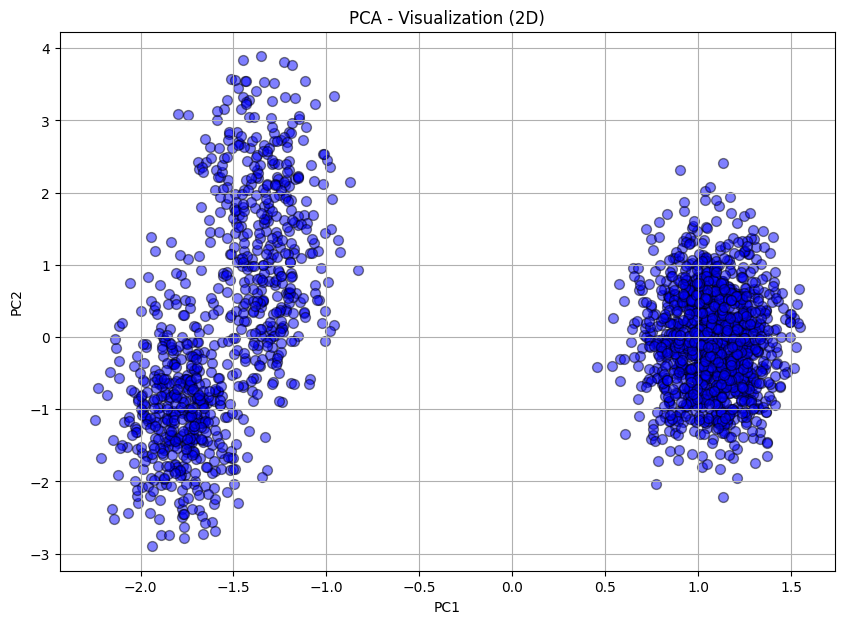

In [ ]:
# Visualize data with 2 principal components
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=50, alpha=0.5)
plt.title("PCA - Visualization (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.savefig('Clutering_PCA_2D.png')
plt.show()

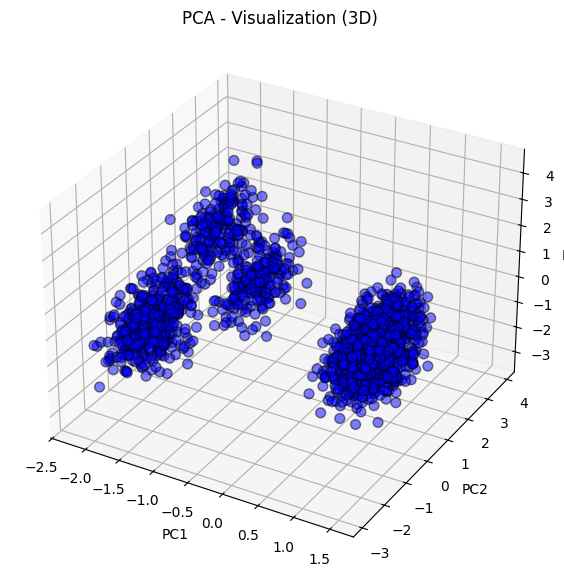

In [ ]:
# Visualize data with 3 principal components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='blue', edgecolor='k', s=50, alpha=0.5)
ax.set_title("PCA - Visualization (3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.grid(True)
plt.savefig('Clutering_PCA_3D.png')
plt.show()

###Kmeans

Thử nghiệm thuật toán K-means với số cụm 𝑘 lấy từ list [2,3,4,5,6,7,8,9,10,11,12,13,14,15] trên tập dữ liệu đã giảm chiều (X_pca).

Với mỗi giá trị 𝑘 , chương trình huấn luyện mô hình, gán nhãn cho tất cả điểm dữ liệu, rồi tính ba chỉ số đánh giá chất lượng phân cụm: Silhouette (cao hơn nghĩa là cụm tách biệt rõ), Davies–Bouldin (thấp hơn càng tốt, biểu thị cụm ít chồng lấn) và Calinski–Harabasz (cao hơn cho thấy cụm chặt và khác biệt).

Kết quả của từng 𝑘 được lưu lại, in ra màn hình và vẽ trên ba biểu đồ đường để phân tích dễ dàng quan sát xu hướng và chọn giá trị 𝑘 tối ưu.

In [ ]:
n_pca_kmeans = 5
X_kmeans = X_pca[:, :n_pca_kmeans]

k= 2 | Sil=0.3073 | DB=1.6048 | CH=751.13
k= 3 | Sil=0.3474 | DB=1.4398 | CH=689.29
k= 4 | Sil=0.3766 | DB=1.0342 | CH=711.98
k= 5 | Sil=0.2783 | DB=1.2602 | CH=709.62
k= 6 | Sil=0.2700 | DB=1.1923 | CH=687.26
k= 7 | Sil=0.2500 | DB=1.3103 | CH=642.07
k= 8 | Sil=0.2386 | DB=1.3436 | CH=601.83
k= 9 | Sil=0.2335 | DB=1.2944 | CH=568.90
k=10 | Sil=0.2322 | DB=1.2987 | CH=544.63
k=11 | Sil=0.2197 | DB=1.3946 | CH=520.29
k=12 | Sil=0.2119 | DB=1.3833 | CH=500.33
k=13 | Sil=0.1961 | DB=1.4474 | CH=484.63
k=14 | Sil=0.1964 | DB=1.4296 | CH=464.97
k=15 | Sil=0.1978 | DB=1.4408 | CH=453.04


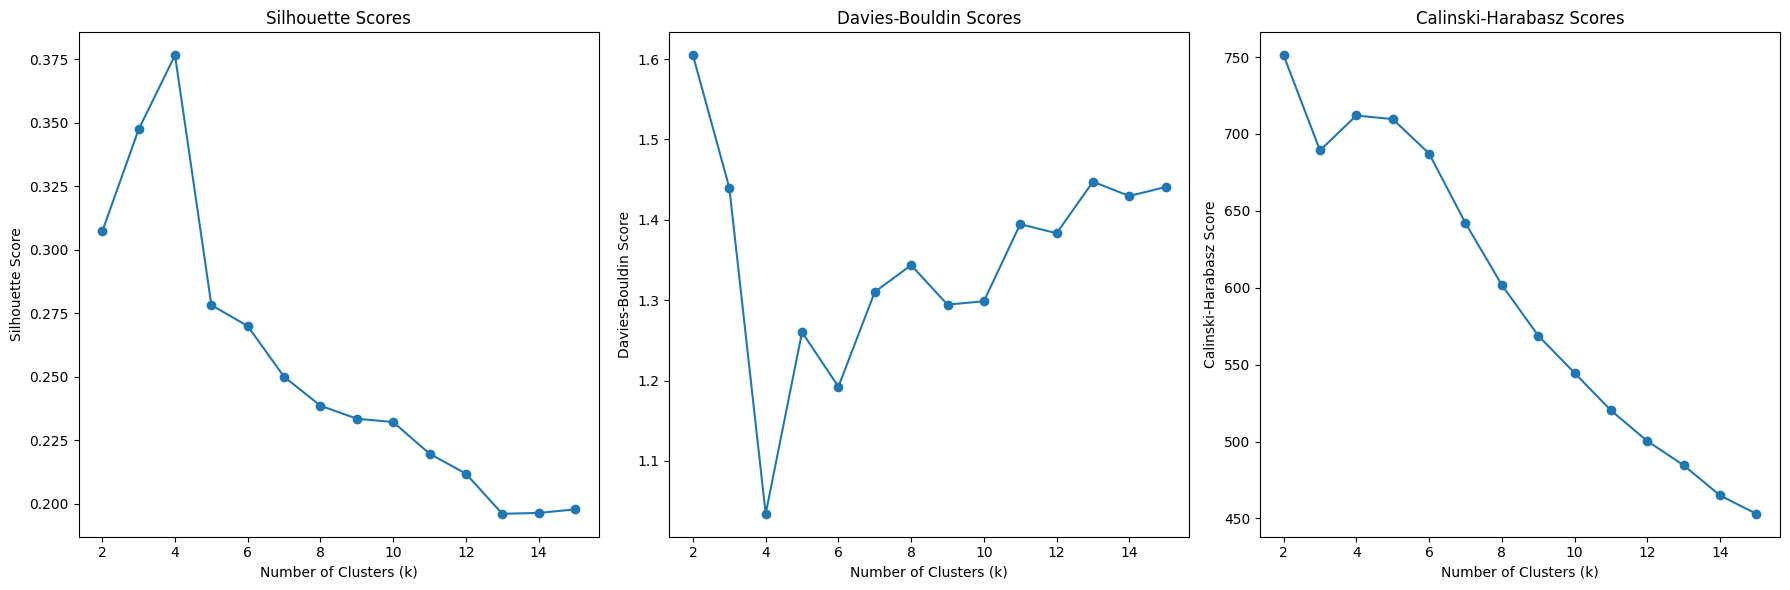

In [ ]:
# Xác định phạm vi của k
k_list = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# Khởi tạo các list để lưu kết quả
sil_scores = []
db_scores = []
ch_scores = []

# Thử các giá trị k từ 2 đến 15
for k in k_list:
    # KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_kmeans)

    sil_scores.append(silhouette_score(X_kmeans, labels))
    db_scores.append(davies_bouldin_score(X_kmeans, labels))
    ch_scores.append(calinski_harabasz_score(X_kmeans, labels))

    print(f"k={k:2d} | Sil={sil_scores[-1]:.4f} | DB={db_scores[-1]:.4f} | CH={ch_scores[-1]:.2f}")

# Vẽ đồ thị Silhouette score, Davies-Bouldin score và Calinski-Harabasz score để tìm số cụm tối ưu
plt.figure(figsize=(18, 6))

# Vẽ Silhouette score
plt.subplot(1, 3, 1)
plt.plot(k_list, sil_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Vẽ Davies-Bouldin score
plt.subplot(1, 3, 2)
plt.plot(k_list, db_scores, marker='o')
plt.title('Davies-Bouldin Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')

# Vẽ Calinski-Harabasz score
plt.subplot(1, 3, 3)
plt.plot(k_list, ch_scores, marker='o')
plt.title('Calinski-Harabasz Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

Chạy dữ liệu với K được chọn ở trên

In [ ]:
best_k = k_list[np.argmax(sil_scores)]
print("Best k by Silhouette:", best_k)

Best k by Silhouette: 4


In [ ]:
# KMeans model từ K đã chọn
kmeans = KMeans(n_clusters= 4, random_state=0, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

Tìm các tâm cụm của dữ liệu

In [ ]:
# labels of KMeans
centers = kmeans.cluster_centers_
print(centers)

[[-1.78720016e+00 -1.06328518e+00 -4.96789779e-01 -1.56977779e-01
  -4.33005414e-01  3.47140575e-01 -8.31229166e-02  5.44621554e-01
   2.56908867e-01 -1.70071146e-01  4.18440710e-02 -2.12864353e-01
   1.64769141e-01  1.25971337e-02  6.23415441e-02 -5.07946325e-02
   2.74788044e-02 -7.84740313e-02  7.10191446e-02 -2.08552459e-02
  -1.30541540e-01 -3.56492984e-03  8.00846127e-02  7.46716509e-03
   7.84275670e-02]
 [ 1.07200576e+00 -6.76420086e-02 -4.50128737e-02  1.27207512e-02
  -2.39805399e-02 -9.02074789e-03  2.43236877e-02 -1.68274919e-03
   2.76111191e-02 -2.76379595e-02 -2.60202446e-02 -7.55963796e-02
  -1.81013367e-02 -6.63697911e-03  7.75320617e-03  3.05717101e-03
   3.48559279e-02 -6.83801728e-03  2.05837052e-02 -3.66541464e-02
   1.07146562e-02 -1.73968729e-02 -1.89144716e-02  1.57410170e-02
   2.36546236e-03]
 [-1.33862406e+00  2.22483108e+00 -9.97998584e-01 -1.43159511e-01
   3.14594026e-01  1.63169406e-01 -2.98622010e-01 -9.37345409e-01
  -3.11037608e-01  8.28588969e-01  4.5

Trực quan dữ liệu sau khi phân cụm KMeans trên 2 thành phần chính.

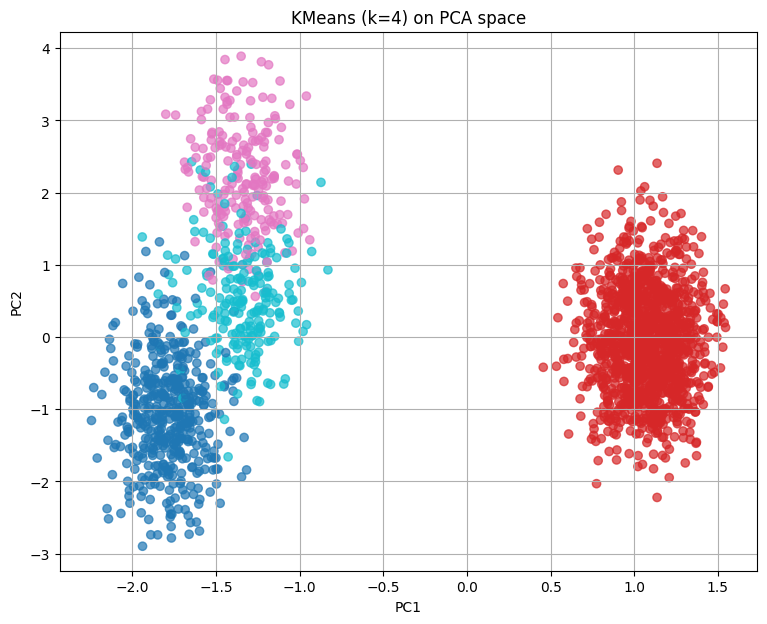

In [ ]:
plt.figure(figsize=(9, 7))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels, cmap='tab10', alpha=0.7)

plt.title(f"KMeans (k={best_k}) on PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

Trực quan dữ liệu sau khi phân cụm KMeans trên 3 thành phần chính.

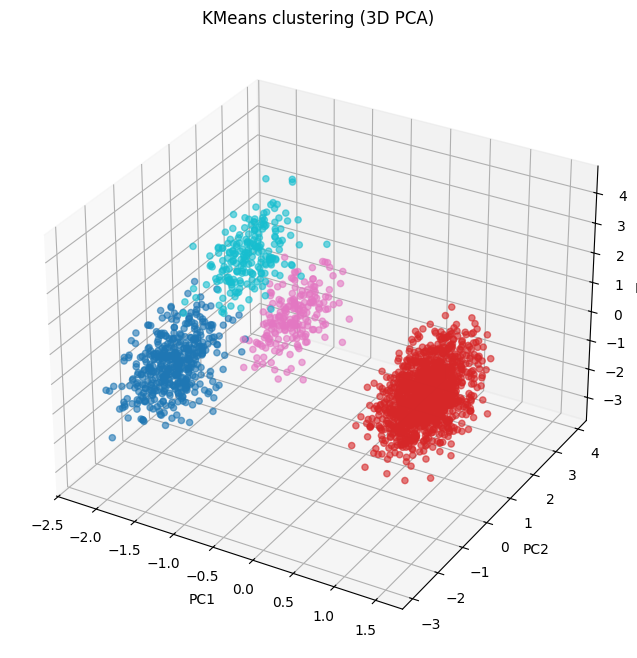

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=kmeans_labels, cmap='tab10', alpha=0.6
)

ax.set_title("KMeans clustering (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

Tần suất phân bố mỗi cụm

In [ ]:
import pandas as pd

# Tạo DataFrame để dễ phân tích
df1 = pd.DataFrame({'Cluster': kmeans_labels, 'Output': y.values.flatten()})

# Đếm tần suất nhãn trong mỗi cụm
cluster_counts = df1.groupby(['Cluster', 'Output']).size().unstack(fill_value=0)
print(cluster_counts)

Output     0    1
Cluster          
0        308  146
1        815  463
2        122   84
3        144   67


###DBScan

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# Giảm PCA xuống 5 chiều
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2. Hàm Grid Search tìm Eps tốt nhất
def find_best_dbscan_params(X_data):
    best_sil_score = -1
    best_db_score = float('inf')
    best_ch_score = -1
    best_params = (None, None)
    best_labels = None

    # Khoảng eps dựa trên K-distance
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(X_data)
    dists, _ = neigh.kneighbors(X_data)
    # Quét eps từ percentile 5 đến 95 của khoảng cách
    eps_range = np.linspace(np.percentile(dists[:, -1], 5), np.percentile(dists[:, -1], 95), 50)

    for min_samples in [3, 5, 10]: # Thử các min_samples phổ biến
        for eps in eps_range:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X_data)

            # Điều kiện lọc kết quả rác:
            #  Phải có ít nhất 2 cụm (không tính nhiễu -1)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            #  Số lượng nhiễu không quá 50% dữ liệu
            if n_clusters >= 2 and n_noise < 0.5 * len(X_data):
                current_sil_score = silhouette_score(X_data, labels)
                current_db_score = davies_bouldin_score(X_data, labels)
                current_ch_score = calinski_harabasz_score(X_data, labels)

                if current_sil_score > best_sil_score:
                    best_sil_score = current_sil_score
                    best_db_score = current_db_score
                    best_ch_score = current_ch_score
                    best_params = (eps, min_samples)
                    best_labels = labels

    return best_params, best_sil_score, best_db_score, best_ch_score, best_labels

(best_eps, best_min), best_sil, best_db, best_ch, dbscan_labels_pca = find_best_dbscan_params(X_pca)

if best_eps is None:
    print("Không tìm thấy tham số phù hợp.")
else:
    print(f"Tham số tốt nhất: Eps={best_eps:.3f}, Min_samples={best_min}")
    print(f"Silhouette Score: {best_sil:.3f}")
    print(f"Calinski-Harabasz Score: {best_ch:.2f}")

Tham số tốt nhất: Eps=1.042, Min_samples=10
Silhouette Score: 0.338
Calinski-Harabasz Score: 457.31


Chạy DBSCAN với tham số tốt nhất

In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min)
labels = dbscan.fit_predict(X_pca)

số cụm và phân bố cụm

In [ ]:
import pandas as pd

df_analysis = pd.DataFrame({
    'Cluster': labels,
    'Diagnosis': y.values.flatten()
})

# Đếm tần suất nhãn trong mỗi cụm
print("Bảng Tần số ")
cluster_counts = df_analysis.groupby(['Cluster', 'Diagnosis']).size().unstack(fill_value=0)
print(cluster_counts)

Bảng Tần số 
Diagnosis    0    1
Cluster            
-1          86   54
 0         805  457
 1         119   50
 2         288  133
 3          91   66


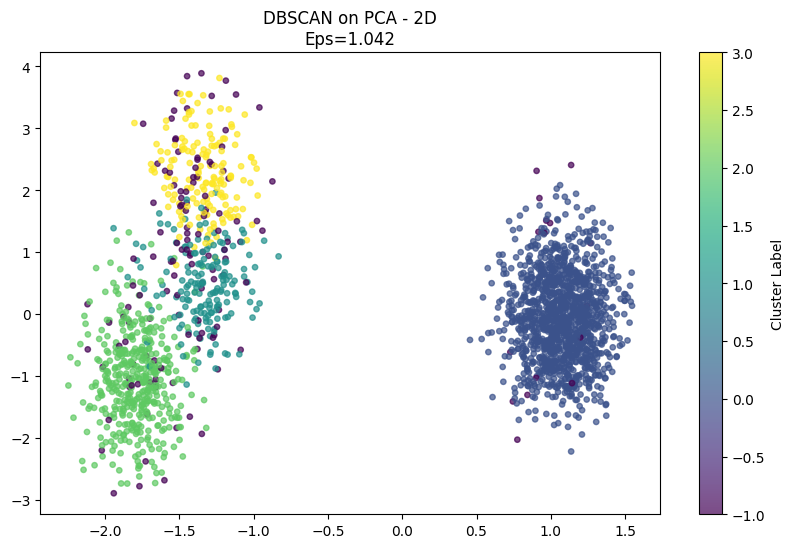

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=15, alpha=0.7)
plt.title(f'DBSCAN on PCA - 2D\nEps={best_eps:.3f}')
plt.colorbar(label='Cluster Label')
plt.show()

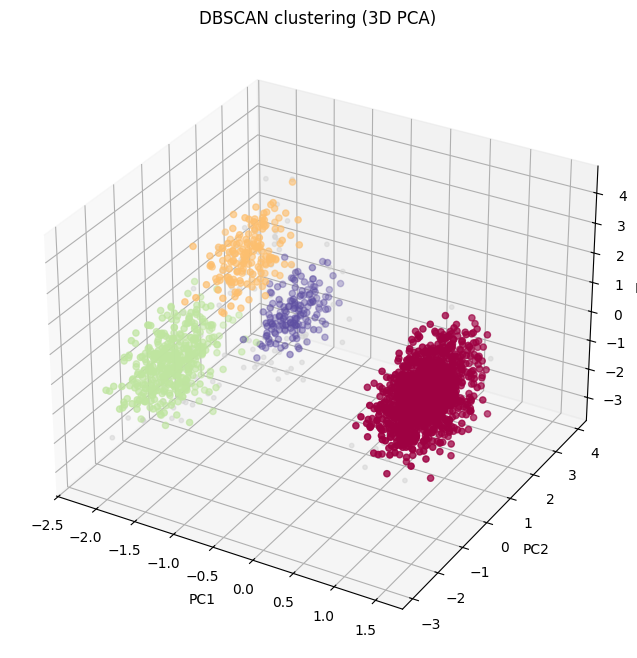

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ điểm nhiễu trước (màu xám, mờ, nằm dưới)
noise_mask = labels == -1
ax.scatter(
    X_pca[noise_mask, 0], X_pca[noise_mask, 1], X_pca[noise_mask, 2],
    c='lightgray', s=10, label='Noise', alpha=0.5
)

# Vẽ các điểm thuộc cụm (màu sắc rực rỡ)
cluster_mask = ~noise_mask
scatter = ax.scatter(
    X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], X_pca[cluster_mask, 2],
    c=labels[cluster_mask], cmap='Spectral', s=20
)

ax.set_title("DBSCAN clustering (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

##Thuật toán phân cụm với Umap

Giảm chiều dữ liệu bằng Umap

In [ ]:
import umap

# n_neighbors: số lân cận, từ 15-50. Tăng lên để nhìn cấu trúc toàn cục rõ hơn.
# min_dist: khoảng cách tối thiểu giữa các điểm 0.1.
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=10, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
print(f"Dữ liệu sau giảm chiều UMAP: {X_umap.shape}")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dữ liệu sau giảm chiều UMAP: (2149, 10)


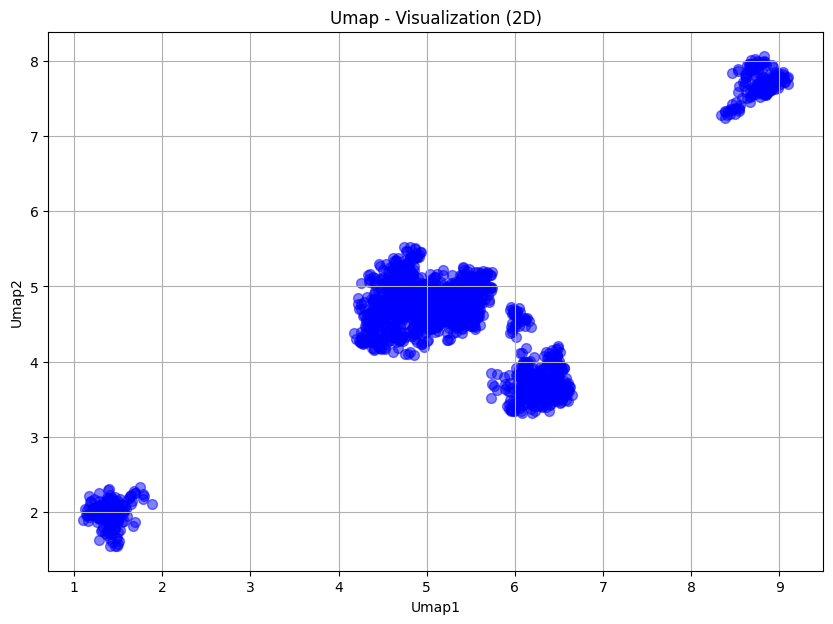

In [ ]:
# Visualize data with 2 principal components
plt.figure(figsize=(10, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c='blue', s=50, alpha=0.5)
plt.title("Umap - Visualization (2D)")
plt.xlabel("Umap1")
plt.ylabel("Umap2")
plt.grid(True)
plt.savefig('Clutering_Umap_2D.png')
plt.show()

###Kmeans

k= 2 | Sil=0.6055 | DB=0.3968 | CH=1458.01
k= 3 | Sil=0.5919 | DB=0.7475 | CH=2561.43
k= 4 | Sil=0.6785 | DB=0.3674 | CH=6786.46
k= 5 | Sil=0.5726 | DB=0.4831 | CH=6710.77
k= 6 | Sil=0.4665 | DB=0.8776 | CH=6380.70
k= 7 | Sil=0.4833 | DB=0.7641 | CH=6053.90
k= 8 | Sil=0.4895 | DB=0.9675 | CH=5941.43
k= 9 | Sil=0.4916 | DB=1.0117 | CH=5673.08
k=10 | Sil=0.5019 | DB=0.9830 | CH=5488.37
k=11 | Sil=0.5141 | DB=1.0009 | CH=5368.61
k=12 | Sil=0.5249 | DB=0.9422 | CH=5290.85
k=13 | Sil=0.4969 | DB=0.9530 | CH=5177.93
k=14 | Sil=0.5070 | DB=0.8692 | CH=5214.71
k=15 | Sil=0.5112 | DB=0.8404 | CH=5119.64


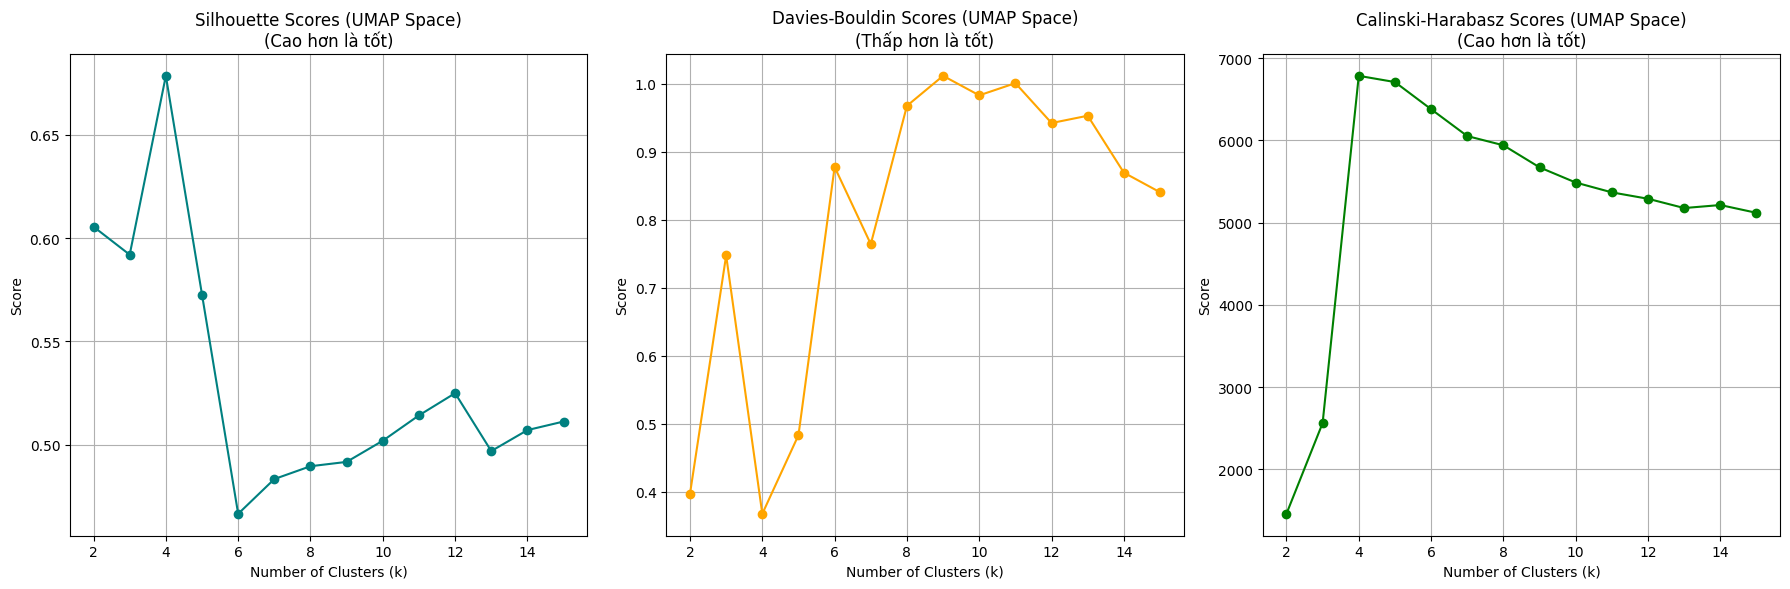

In [ ]:
k_list = range(2, 16) # Từ 2 đến 15

# Khởi tạo các list để lưu kết quả
sil_scores = []
db_scores = []
ch_scores = []

for k in k_list:
    # KMeans model chạy trên dữ liệu UMAP (X_umap)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_umap)

    # Tính toán các chỉ số dựa trên không gian UMAP
    # Truyền X_umap vào hàm tính lỗi
    sil = silhouette_score(X_umap, labels)
    db = davies_bouldin_score(X_umap, labels)
    ch = calinski_harabasz_score(X_umap, labels)

    sil_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)

    print(f"k={k:2d} | Sil={sil:.4f} | DB={db:.4f} | CH={ch:.2f}")

# 4. Vẽ đồ thị đánh giá
plt.figure(figsize=(18, 6))

# Vẽ Silhouette score
plt.subplot(1, 3, 1)
plt.plot(k_list, sil_scores, marker='o', color='teal')
plt.title('Silhouette Scores (UMAP Space)\n(Cao hơn là tốt)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.grid(True)

# Vẽ Davies-Bouldin score
plt.subplot(1, 3, 2)
plt.plot(k_list, db_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Scores (UMAP Space)\n(Thấp hơn là tốt)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.grid(True)

# Vẽ Calinski-Harabasz score
plt.subplot(1, 3, 3)
plt.plot(k_list, ch_scores, marker='o', color='green')
plt.title('Calinski-Harabasz Scores (UMAP Space)\n(Cao hơn là tốt)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 5. In ra k tốt nhất dựa trên Silhouette
best_k_umap = k_list[np.argmax(sil_scores)]
print(f"\nSố cụm tốt nhất trên không gian UMAP (theo Silhouette) là: k = {best_k_umap}")


Số cụm tốt nhất trên không gian UMAP (theo Silhouette) là: k = 4


In [ ]:
# 4. Phân cụm K-Means trên không gian 2D mới
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_umap)

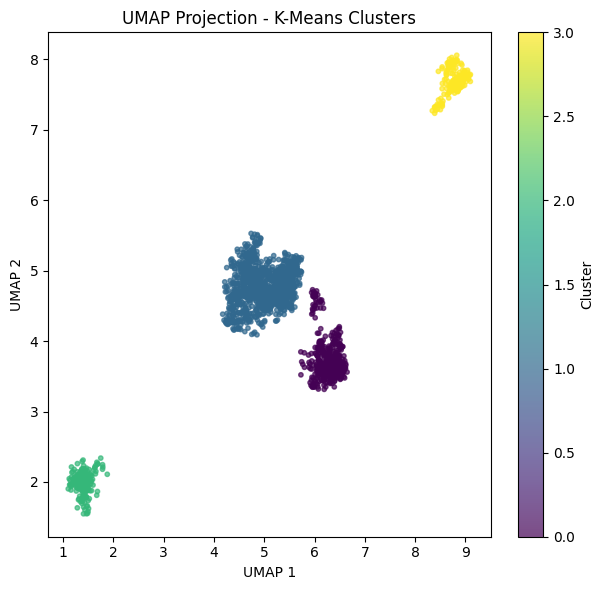

In [ ]:
# 5. Trực quan hóa kết quả
plt.figure(figsize=(12, 6))

# Biểu đồ 1: Kết quả phân cụm K-Means trên nền UMAP
plt.subplot(1, 2, 1)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
plt.title('UMAP Projection - K-Means Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

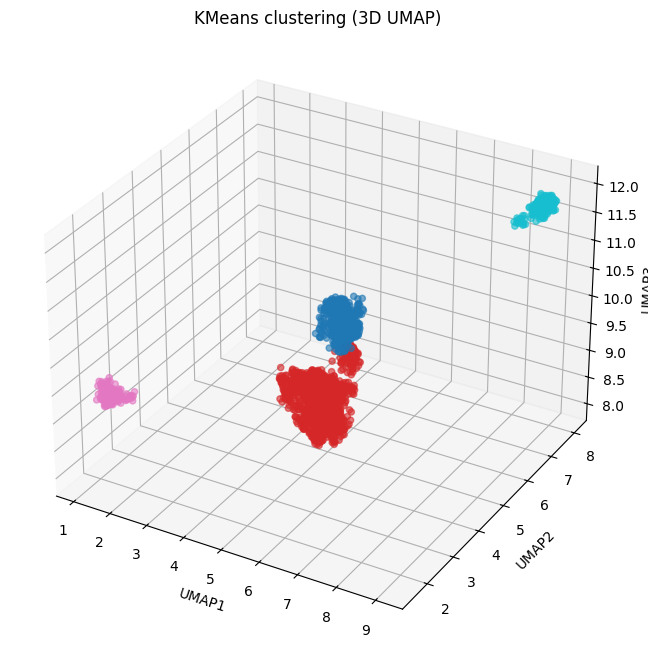

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=labels, cmap='tab10', alpha=0.6
)

ax.set_title("KMeans clustering (3D UMAP)")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
plt.show()

Tần số phân cụm

In [ ]:
# Tạo DataFrame để dễ phân tích
df1 = pd.DataFrame({'Cluster': labels, 'Output': y.values.flatten()})

# Đếm tần suất nhãn trong mỗi cụm
cluster_counts_umap = df1.groupby(['Cluster', 'Output']).size().unstack(fill_value=0)
print("\n Bảng tần suất phân bố (UMAP + KMeans)")
print(cluster_counts_umap)


 Bảng tần suất phân bố (UMAP + KMeans)
Output     0    1
Cluster          
0        307  146
1        816  463
2        144   67
3        122   84


###DBScan

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
best_score = -1
best_params = (None, None)
best_labels = None
best_ch_score = -1 # Initialize best Calinski-Harabasz score
min_samples_list = [3,5,10]
for min_samples in min_samples_list:
    # Xác định khoảng eps dựa trên K-distance
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X_umap)
    dists, _ = neigh.kneighbors(X_umap)
    k_dists = dists[:, -1]

    # Quét eps từ percentile 50 đến 99
    eps_candidates = np.linspace(np.percentile(k_dists, 50),
                                 np.percentile(k_dists, 99), 30)

    for eps in eps_candidates:
        # Chạy DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_umap)

        # Kiểm tra điều kiện & Tính điểm
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Điều kiện chấp nhận:
        # 1. Có ít nhất 2 cụm
        # 2. Nhiễu không quá 40%
        if n_clusters >= 2 and n_noise < 0.4 * len(X_umap):

            # CHỈ tính Silhouette Score trên các điểm thuộc cụm (Bỏ nhiễu -1)
            mask = labels != -1
            if len(set(labels[mask])) >= 2: # Phải còn ít nhất 2 cụm sau khi lọc
                score = silhouette_score(X_umap[mask], labels[mask])
                ch_score = calinski_harabasz_score(X_umap[mask], labels[mask])

                # Lưu lại nếu kết quả tốt hơn
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_labels = labels
                    best_ch_score = ch_score # Store CH score for the best params

print(f"Best parameters: Eps={best_params[0]:.3f}, Min_samples={best_params[1]}")
print(f"Best silhouette score: {best_score:.3f}")
print(f"Best calinski harabasz score: {best_ch_score:.2f}")

Best parameters: Eps=0.415, Min_samples=10
Best silhouette score: 0.579
Best calinski harabasz score: 5141.50


Tần số thống kê phân bố cụm

In [ ]:
import pandas as pd

#Tạo DataFrame kết hợp kết quả cluster
df_analysis = pd.DataFrame({
    'Cluster': best_labels,
    'Diagnosis': y
})
#Tạo bảng thống kê chéo
cross_tab = pd.crosstab(df_analysis['Cluster'], df_analysis['Diagnosis'])

print("\n Bảng phân bố chi tiết")
print(cross_tab)


 Bảng phân bố chi tiết
Diagnosis    0    1
Cluster            
-1         153  111
 0         144   67
 1          26   47
 2         274  134
 3          30   18
 4          56   19
 5          42   24
 6          35   13
 7          55   29
 8         122   84
 9          80   25
 10        117   46
 11         74   37
 12         27   10
 13         24   39
 14         23    7
 15         86   39
 16         13    3
 17          8    8


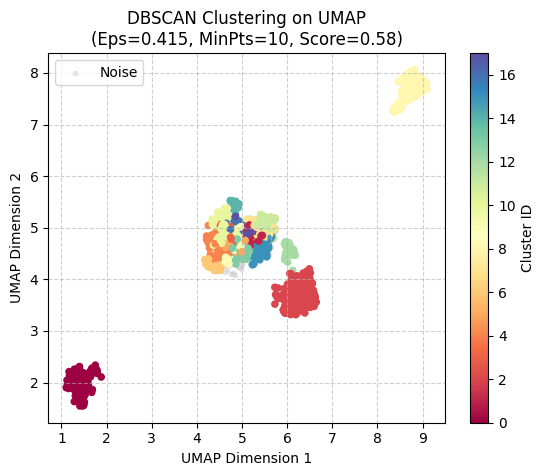

In [ ]:
  # Vẽ điểm nhiễu trước (màu xám, mờ, nằm dưới)
noise_mask = best_labels == -1
plt.scatter(X_umap[noise_mask, 0], X_umap[noise_mask, 1],
            c='lightgray', s=10, label='Noise', alpha=0.5)

    # Vẽ các điểm thuộc cụm (màu sắc rực rỡ)
cluster_mask = ~noise_mask
scatter = plt.scatter(X_umap[cluster_mask, 0], X_umap[cluster_mask, 1],
                      c=best_labels[cluster_mask], cmap='Spectral', s=20)

  # Tạo colorbar
plt.colorbar(scatter, label='Cluster ID')
plt.title(f'DBSCAN Clustering on UMAP\n(Eps={best_params[0]:.3f}, MinPts={best_params[1]}, Score={best_score:.2f})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

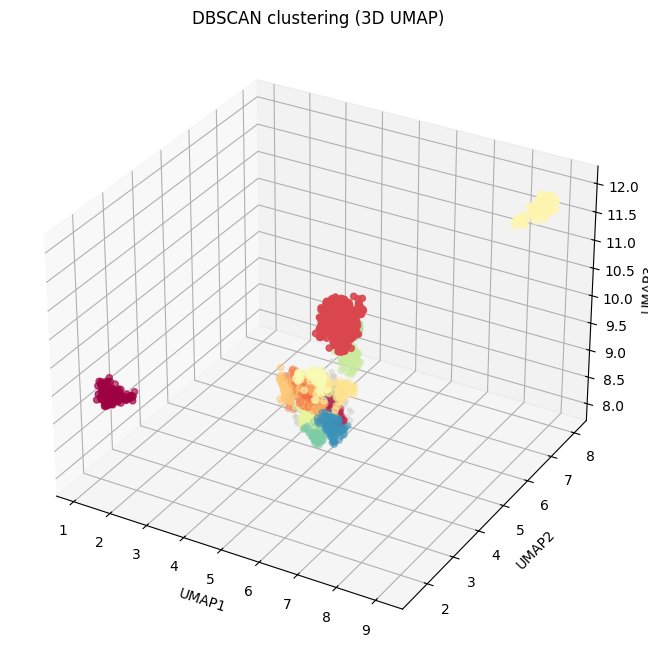

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ điểm nhiễu trước (màu xám, mờ, nằm dưới)
noise_mask = best_labels == -1
ax.scatter(
    X_umap[noise_mask, 0], X_umap[noise_mask, 1], X_umap[noise_mask, 2],
    c='lightgray', s=10, label='Noise', alpha=0.5
)

# Vẽ các điểm thuộc cụm (màu sắc rực rỡ)
cluster_mask = ~noise_mask
scatter = ax.scatter(
    X_umap[cluster_mask, 0], X_umap[cluster_mask, 1], X_umap[cluster_mask, 2],
    c=best_labels[cluster_mask], cmap='Spectral', s=20
)

ax.set_title("DBSCAN clustering (3D UMAP)")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
plt.show()

#2-Phân loại bằng phương pháp SVM

In [ ]:
X = df.drop('Diagnosis', axis=1)
#axis=1 argument indicates that we are dropping a column (as opposed to a row)
y = df['Diagnosis']

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

binary_cols = ['BehavioralProblems', 'CardiovascularDisease', 'Confusion', 'Depression', 'Diabetes', 'DifficultyCompletingTasks', 'Disorientation', 'FamilyHistoryAlzheimers', 'Forgetfulness', 'Gender', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'PersonalityChanges', 'Smoking']
nominal_cols = ['Ethnicity', 'EducationLevel']   # nominal categories
continuous_cols = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(drop='first'), nominal_cols)
        #When drop='first' is set to True, it removes the first category for each feature being one-hot encoded.
    ]
)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform, randint # Added randint for PCA n_components
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, classification_report

split_ratios = [0.2, 0.3, 0.4]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter distributions for RandomizedSearchCV
# Parameters are now prefixed with the pipeline step names (e.g., 'pca__', 'svc__')
param_distributions = {
    'svc__C': loguniform(0.00001, 10000),  # Log-uniform distribution for C
    'svc__gamma': loguniform(0.001, 100), # Log-uniform distribution for gamma
    'svc__coef0': [-1, 0, 1, 10],
    'svc__kernel': ['linear', 'poly', 'sigmoid', 'rbf']
}

##Dữ liệu ban đầu

In [ ]:
# Define the pipeline steps: preprocessing, PCA, and SVC
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

# Initialize RandomizedSearchCV with the pipeline
random_search = RandomizedSearchCV(
    pipeline,                     # Pass the entire pipeline here
    param_distributions,
    n_iter=50, # Sample 50 different parameter combinations (adjust as needed)
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 # For reproducibility
)

for i in split_ratios:
    print(f"Test size: {i}")

    # Split the ORIGINAL data (X, y), not the pre-processed X_processed
    # The pipeline will handle preprocessing and PCA fitting/transforming internally
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=i, stratify=y, random_state=42
    )

    # Fit the randomized search to the raw training data. The pipeline handles all steps.
    random_search.fit(X_train, y_train)

    # Get all results and sort them
    results_df = pd.DataFrame(random_search.cv_results_)
    sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

    print("\nTop 3 models from RandomizedSearchCV (excluding best which is printed above):")
    # Display top 3 models (first one is the best, next two are second and third)
    for rank, (index, row) in enumerate(sorted_results.head(3).iterrows()):
        print(f"Rank {rank + 1}:")
        print(f"  Mean Test Score: {row['mean_test_score']:.4f}")
        print(f"  Parameters: {row['params']}")
        print("\n")

    print("Best parameters found (RandomizedSearchCV): ", random_search.best_params_)
    print("Best accuracy score found (RandomizedSearchCV): ", random_search.best_score_)

    # Evaluate the best estimator on the test data for test accuracy
    best_svc_model = random_search.best_estimator_ # This is now the fitted pipeline
    y_pred_test = best_svc_model.predict(X_test)

    print("Test accuracy score (RandomizedSearchCV): ", best_svc_model.score(X_test, y_test))
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))


Test size: 0.2

Top 3 models from RandomizedSearchCV (excluding best which is printed above):
Rank 1:
  Mean Test Score: 0.8546
  Parameters: {'svc__C': np.float64(310.44435499483166), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0010090061869151559), 'svc__kernel': 'rbf'}


Rank 2:
  Mean Test Score: 0.8470
  Parameters: {'svc__C': np.float64(23.585940584142634), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0019145111285710716), 'svc__kernel': 'rbf'}


Rank 3:
  Mean Test Score: 0.8429
  Parameters: {'svc__C': np.float64(0.39511700681839573), 'svc__coef0': -1, 'svc__gamma': np.float64(0.2655521712973634), 'svc__kernel': 'linear'}


Best parameters found (RandomizedSearchCV):  {'svc__C': np.float64(310.44435499483166), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0010090061869151559), 'svc__kernel': 'rbf'}
Best accuracy score found (RandomizedSearchCV):  0.8545562411010916
Test accuracy score (RandomizedSearchCV):  0.8348837209302326
[[241  37]
 [ 34 118]]
              precision    recal

**SVC trên dữ liệu gốc (chưa giảm chiều):**

- **Độ chính xác cao nhất:** 0.8512 (đạt được với test_size = 0.3)

- **Tham số tốt nhất:** {'svc__C': 310.44, 'svc__coef0': 0, 'svc__gamma': 0.0010, 'svc__kernel': 'rbf'}

- **Nhận xét:** Kernel RBF với giá trị C tương đối lớn và gamma nhỏ cho kết quả tốt nhất, cho thấy một biên quyết định phi tuyến nhưng tương đối mượt là tối ưu. Mô hình đạt được sự cân bằng tốt giữa độ chính xác (precision) và độ bao phủ (recall) cho cả hai lớp.

##Dữ liệu giảm chiều

###PCA

In [ ]:
# Define the pipeline steps: preprocessing, PCA, and SVC
pipeline = Pipeline([
    ('preprocessor', preprocessor), # Uses the preprocessor defined in an earlier cell
    ('pca', PCA(n_components=15)),                 # PCA step; n_components will be tuned
    ('svc', SVC())                  # SVC classifier
])

# Initialize RandomizedSearchCV with the pipeline
random_search = RandomizedSearchCV(
    pipeline,                     # Pass the entire pipeline here
    param_distributions,
    n_iter=50, # Sample 50 different parameter combinations (adjust as needed) = 50 * 5 CV = 250 fits
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 # For reproducibility
)

print("\n--- Running SVC on PCA-reduced Data ---\n")
for i in split_ratios:
    print(f"Test size: {i}")

    # Split the ORIGINAL data (X, y), not the pre-processed X_processed
    # The pipeline will handle preprocessing and PCA fitting/transforming internally
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=i, stratify=y, random_state=42
    )

    # Fit the randomized search to the raw training data. The pipeline handles all steps.
    random_search.fit(X_train, y_train)

    # Get all results and sort them
    results_df = pd.DataFrame(random_search.cv_results_)
    sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

    print("\nTop 3 models from RandomizedSearchCV (excluding best which is printed above):")
    # Display top 3 models (first one is the best, next two are second and third)
    for rank, (index, row) in enumerate(sorted_results.head(3).iterrows()):
        print(f"Rank {rank + 1}:")
        print(f"  Mean Test Score: {row['mean_test_score']:.4f}")
        print(f"  Parameters: {row['params']}")
        print("\n")

    print("Best parameters found (RandomizedSearchCV): ", random_search.best_params_)
    print("Best accuracy score found (RandomizedSearchCV): ", random_search.best_score_)

    # Evaluate the best estimator on the test data for test accuracy
    best_svc_model = random_search.best_estimator_ # This is now the fitted pipeline
    y_pred_test = best_svc_model.predict(X_test)

    print("Test accuracy score (RandomizedSearchCV): ", best_svc_model.score(X_test, y_test))
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))



--- Running SVC on PCA-reduced Data ---

Test size: 0.2

Top 3 models from RandomizedSearchCV (excluding best which is printed above):
Rank 1:
  Mean Test Score: 0.7760
  Parameters: {'svc__C': np.float64(310.44435499483166), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0010090061869151559), 'svc__kernel': 'rbf'}


Rank 2:
  Mean Test Score: 0.7725
  Parameters: {'svc__C': np.float64(23.585940584142634), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0019145111285710716), 'svc__kernel': 'rbf'}


Rank 3:
  Mean Test Score: 0.7714
  Parameters: {'svc__C': np.float64(0.4247270739805822), 'svc__coef0': 10, 'svc__gamma': np.float64(0.21568228019263963), 'svc__kernel': 'linear'}


Best parameters found (RandomizedSearchCV):  {'svc__C': np.float64(310.44435499483166), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0010090061869151559), 'svc__kernel': 'rbf'}
Best accuracy score found (RandomizedSearchCV):  0.776028883314123
Test accuracy score (RandomizedSearchCV):  0.8162790697674419
[[260  18]
 [ 

**SVC trên dữ liệu đã giảm chiều bằng PCA (n_components = 15):**

- **Best Test Accuracy:** 0.8163 (đạt được với test_size = 0.2)

- **Tham số tốt nhất (Best Parameters):** {'svc__C': 310.44, 'svc__coef0': 0, 'svc__gamma': 0.0010, 'svc__kernel': 'rbf'}

- **Nhận xét:** Độ chính xác trên tập kiểm tra giảm đáng kể so với khi sử dụng dữ liệu gốc, cho thấy mặc dù PCA giúp giảm số chiều, nhưng đã loại bỏ một số thông tin phân biệt quan trọng (PCA với 15 thành phần chính chỉ giữ đc ~84% thông tin). Đáng chú ý là các tham số tối ưu (kernel RBF, giá trị C và gamma tương tự) gần như trùng với trường hợp dữ liệu gốc, hàm ý rằng mô hình vẫn đang tìm kiếm mối quan hệ phi tuyến nền tảng, nhưng với tập đặc trưng kém hiệu quả hơn.

###LDA

In [ ]:
# Define the pipeline steps: preprocessing, PCA, and SVC
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lda', LDA(n_components=1)),
    ('svc', SVC())
])

# Initialize RandomizedSearchCV with the pipeline
random_search = RandomizedSearchCV(
    pipeline,                     # Pass the entire pipeline here
    param_distributions,
    n_iter=50, # Sample 50 different parameter combinations (adjust as needed)
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 # For reproducibility
)

print("\n--- Running SVC on LDA-reduced Data ---\n")
for i in split_ratios:
    print(f"Test size: {i}")

    # Split the ORIGINAL data (X, y), not the pre-processed X_processed
    # The pipeline will handle preprocessing and PCA fitting/transforming internally
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=i, stratify=y, random_state=42
    )

    # Fit the randomized search to the raw training data. The pipeline handles all steps.
    random_search.fit(X_train, y_train)

    # Get all results and sort them
    results_df = pd.DataFrame(random_search.cv_results_)
    sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

    print("\nTop 3 models from RandomizedSearchCV (excluding best which is printed above):")
    # Display top 3 models (first one is the best, next two are second and third)
    for rank, (index, row) in enumerate(sorted_results.head(3).iterrows()):
        print(f"Rank {rank + 1}:")
        print(f"  Mean Test Score: {row['mean_test_score']:.4f}")
        print(f"  Parameters: {row['params']}")
        print("\n")

    print("Best parameters found (RandomizedSearchCV): ", random_search.best_params_)
    print("Best accuracy score found (RandomizedSearchCV): ", random_search.best_score_)

    # Evaluate the best estimator on the test data for test accuracy
    best_svc_model = random_search.best_estimator_ # This is now the fitted pipeline
    y_pred_test = best_svc_model.predict(X_test)

    print("Test accuracy score (RandomizedSearchCV): ", best_svc_model.score(X_test, y_test))
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))



--- Running SVC on LDA-reduced Data ---

Test size: 0.2

Top 3 models from RandomizedSearchCV (excluding best which is printed above):
Rank 1:
  Mean Test Score: 0.8400
  Parameters: {'svc__C': np.float64(0.5065186776865478), 'svc__coef0': 1, 'svc__gamma': np.float64(0.003584710633004181), 'svc__kernel': 'rbf'}


Rank 2:
  Mean Test Score: 0.8400
  Parameters: {'svc__C': np.float64(23.585940584142634), 'svc__coef0': 0, 'svc__gamma': np.float64(0.0019145111285710716), 'svc__kernel': 'rbf'}


Rank 3:
  Mean Test Score: 0.8394
  Parameters: {'svc__C': np.float64(2.4049154327373503), 'svc__coef0': 10, 'svc__gamma': np.float64(0.04292436152765813), 'svc__kernel': 'poly'}


Best parameters found (RandomizedSearchCV):  {'svc__C': np.float64(0.5065186776865478), 'svc__coef0': 1, 'svc__gamma': np.float64(0.003584710633004181), 'svc__kernel': 'rbf'}
Best accuracy score found (RandomizedSearchCV):  0.8400179673198183
Test accuracy score (RandomizedSearchCV):  0.813953488372093
[[243  35]
 [ 45 1

**SVC trên dữ liệu đã giảm chiều bằng LDA (n_components = 1):**

- **Best Test Accuracy:** 0.8302 (đạt được với test_size = 0.4)

- **Tham số tốt nhất (Best Parameters):** {'svc__C': 2.4049, 'svc__coef0': 10, 'svc__gamma': 0.0429, 'svc__kernel': 'poly'}

- **Nhận xét:** Dữ liệu sau khi giảm chiều bằng LDA (chỉ còn 1 thành phần) cho độ chính xác trên tập kiểm tra cao hơn so với PCA, nhưng vẫn thấp hơn so với dữ liệu gốc. Điều này cho thấy phương pháp giảm chiều có giám sát của LDA, vốn tập trung vào khả năng phân tách giữa các lớp, hiệu quả hơn PCA - phương pháp chỉ bảo toàn phương sai - trong bối cảnh này. Kernel tối ưu ở đây là 'poly', một sự thay đổi đáng kể so với 'rbf' trong hai kịch bản còn lại. Điều này gợi ý rằng trong không gian 1 chiều do LDA tạo ra, biên quyết định dạng đa thức hiệu quả hơn RBF trong việc phân tách các lớp.

#**Kết luận:**

1, Bản chất của dữ liệu và mức độ phù hợp của mô hình:

- Hiệu năng tốt nhất đạt được khi sử dụng bộ dữ liệu gốc với đầy đủ đặc trưng, điều này cho thấy tất cả (hoặc ít nhất là phần lớn) các đặc trưng đều đóng vai trò quan trọng trong việc phân biệt giữa các lớp. Việc kernel tối ưu là 'rbf' đối với dữ liệu gốc cho thấy mối quan hệ giữa các đặc trưng và biến 'Diagnosis' mang tính phi tuyến và phức tạp. SVM, với khả năng xử lý các biên quyết định phi tuyến thông qua kernel, nhìn chung rất phù hợp với kiểu dữ liệu này.

- Cả PCA và LDA, mặc dù giúp giảm số chiều, đều dẫn đến sự suy giảm độ chính xác trên tập kiểm tra + tăng thời gian chạy gridsearch. 'Diagnosis' có thể phụ thuộc vào các mối quan hệ phức tạp trải rộng trên nhiều đặc trưng. Kết quả trực quan hóa giảm chiều cũng cho thấy 2 phương pháp này chưa phân tách đc data một cách hiệu quả, tuy nhiên, kết quả của cả hai đều ko quá tệ, đặc biệt, kết quả của SVM với LDA khá tốt và ổn định so với dự đoán.

2, Tỷ lệ chia Train/Test tốt nhất:

Đối với dữ liệu gốc, test_size = 0.3 cho độ chính xác trên tập kiểm tra cao nhất. Với PCA, giá trị tốt nhất là 0.2, và với LDA là 0.4.

**=> Cân nhắc:**

1, Ưu tiên dữ liệu gốc: tốc độ + độ chính xác vượt trội.

2, Tinh chỉnh siêu tham số sâu hơn cho dữ liệu gốc: Mặc dù RandomizedSearchCV đã thử 50 tổ hợp, việc sử dụng GridSearchCV tập trung quanh các giá trị tốt nhất của C (≈ 300) và gamma (≈ 0.001) cho kernel 'rbf' trên dữ liệu gốc có thể mang lại kết quả tốt hơn nữa.



# 3.1-Chuyển bài toán về dạng hồi quy với Softmax

### Dữ liệu gốc

In [ ]:
df.describe()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,7.051081,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,1.763573,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,4.002629,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,5.482997,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,7.115646,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,8.562521,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,9.999840,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

continuous_cols = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

binary_cols = [
    'Gender', 'Smoking', 'FamilyHistoryAlzheimers',
    'CardiovascularDisease', 'Diabetes', 'Depression',
    'HeadInjury', 'Hypertension', 'MemoryComplaints',
    'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
]

ordinal_cols = ['EducationLevel']

nominal_cols = ['Ethnicity']
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bin_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

ord_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, continuous_cols),
    ('bin', bin_transformer, binary_cols),
    ('ord', ord_transformer, ordinal_cols),
    ('cat', cat_transformer, nominal_cols)
])
pipe_softmax = Pipeline([
    ('preproc', preprocessor),
    ('sel', SelectKBest(score_func=f_classif)),
    ('softmax', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=20000,
        random_state=42
    ))
])
param_grid = {
    'sel__k': [20, 'all'],
    'softmax__C': [0.1, 1, 10]
}
# tim ra to hop so toi uu
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
split_ratios = [0.2, 0.3, 0.4]
results = []

for test_size in split_ratios:
    print(f"\n===== SPLIT {1-test_size:.0%}/{test_size:.0%} =====")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    # GridSearch Softmax
    gs = GridSearchCV(
        pipe_softmax,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1
    )

    gs.fit(X_train, y_train)
    best_softmax = gs.best_estimator_

    # Xác suất lớp 1 từ Softmax
    # kết quả train/test của mô hình hồi quy
    p_train = best_softmax.predict_proba(X_train)[:, 1]
    p_test  = best_softmax.predict_proba(X_test)[:, 1]

    # Dữ liệu đã transform
    X_train_reg = best_softmax.named_steps['preproc'].transform(X_train)
    X_test_reg  = best_softmax.named_steps['preproc'].transform(X_test)

    # Hồi quy
    reg = LinearRegression()
    reg.fit(X_train_reg, p_train)
    # mô hình dự đoán
    p_pred = reg.predict(X_test_reg)

    # Đánh giá
    mse = mean_squared_error(p_test, p_pred)
    mae = mean_absolute_error(p_test, p_pred)
    r2  = r2_score(p_test, p_pred)

    results.append({
        'train/test': f"{1-test_size:.0%}/{test_size:.0%}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

    print(f"MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

In [ ]:
results_df = pd.DataFrame(results)
results_df

### Dữ liệu sau giảm chiều PCA

In [ ]:
### chia ti le truoc ---> pca
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

results = []

for test_size in [0.2, 0.3, 0.4]:
    print(f"\n===== SPLIT {1-test_size:.0%}/{test_size:.0%} =====")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    #pca
    pca = PCA(n_components=10, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)
    # Huấn luyện Softmax Regression
    softmax = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=20000,
        random_state=42
    )
    softmax.fit(X_train_pca, y_train)

    # Xác suất class 1
    p_train = softmax.predict_proba(X_train_pca)[:, 1]
    p_test  = softmax.predict_proba(X_test_pca)[:, 1]

    # sử dụng hồi quy tuyến tính
    reg = LinearRegression()
    reg.fit(p_train.reshape(-1, 1), y_train)

    p_pred = reg.predict(p_test.reshape(-1, 1))

    # đánh giá với mse, mae, r2
    mse = mean_squared_error(p_test, p_pred)
    mae = mean_absolute_error(p_test, p_pred)
    r2  = r2_score(p_test, p_pred)

    results.append({
        'train/test': f"{1-test_size:.0%}/{test_size:.0%}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

    print(f"MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

pd.DataFrame(results)



### Dữ liệu sau giảm chiều LDA

In [ ]:
# lda sau
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

split_ratios = [0.2, 0.3, 0.4]
results = []

for test_size in split_ratios:
    print(f"\n===== SPLIT {1-test_size:.0%}/{test_size:.0%} =====")

    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    # # scale

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc  = scaler.transform(X_test)

    # LDA (fit trên train)
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda  = lda.transform(X_test)

    # Softmax
    softmax = LogisticRegression(
        solver='lbfgs',
        max_iter=20000,
        random_state=42
    )

    softmax.fit(X_train_lda, y_train)

    p_train = softmax.predict_proba(X_train_lda)[:, 1]
    p_test  = softmax.predict_proba(X_test_lda)[:, 1]

    # Hồi quy tuyến tính
    reg = LinearRegression()
    reg.fit(X_train_lda, p_train)

    p_pred = reg.predict(X_test_lda)

    # Đánh giá
    mse = mean_squared_error(p_test, p_pred)
    mae = mean_absolute_error(p_test, p_pred)
    r2  = r2_score(p_test, p_pred)

    results.append({
        'train/test': f"{1-test_size:.0%}/{test_size:.0%}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

    print(f"MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
results_df = pd.DataFrame(results)
results_df

# 3.2-Chuyển bài toán về dạng hồi quy với SVM

### Dữ liệu gốc

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [ ]:
#svm
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)


In [ ]:

split_ratios = [0.2, 0.3, 0.4]
results = []


for test_size in split_ratios:
    print(f"\n===== SPLIT {1-test_size:.0%}/{test_size:.0%} =====")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    # huấn luyện svm
    svm.fit(X_train, y_train)

    # Lấy xác suất lớp 1
    p_train = svm.predict_proba(X_train)[:, 1]
    p_test  = svm.predict_proba(X_test)[:, 1]

    # hồi quy tuyến tính
    reg = LinearRegression()
    reg.fit(X_train, p_train)

    p_pred = reg.predict(X_test)

    # đánh giá qua mse, mae, r2
    mse = mean_squared_error(p_test, p_pred)
    mae = mean_absolute_error(p_test, p_pred)
    r2  = r2_score(p_test, p_pred)

    results.append({
        'train/test': f"{1-test_size:.0%}/{test_size:.0%}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

    print(f"MSE = {mse:.4f}, MAE = {mae:.4f}, R2  = {r2:.4f}")
    print(f"")


results_df = pd.DataFrame(results)
results_df


### Dữ liệu sau giảm chiều PCA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

binary_cols = [
    'BehavioralProblems','CardiovascularDisease','Confusion','Depression',
    'Diabetes','DifficultyCompletingTasks','Disorientation',
    'FamilyHistoryAlzheimers','Forgetfulness','Gender','HeadInjury',
    'Hypertension','MemoryComplaints','PersonalityChanges','Smoking'
]

nominal_cols = ['Ethnicity', 'EducationLevel']

continuous_cols = [
    'Age','BMI','AlcoholConsumption','PhysicalActivity','DietQuality',
    'SleepQuality','SystolicBP','DiastolicBP','CholesterolTotal',
    'CholesterolLDL','CholesterolHDL','CholesterolTriglycerides',
    'MMSE','FunctionalAssessment','ADL'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), binary_cols + nominal_cols)
    ]
)

n_components = 10
split_ratios = [0.2, 0.3, 0.4]
results = []

for test_size in split_ratios:
    print(f"\n===== SPLIT {1-test_size:.0%}/{test_size:.0%} =====")


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep  = preprocessor.transform(X_test)


    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_prep)
    X_test_pca  = pca.transform(X_test_prep)


    svm = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,
        random_state=42
    )
    svm.fit(X_train_pca, y_train)

    # Xác suất lớp 1
    p_train = svm.predict_proba(X_train_pca)[:, 1]
    p_test  = svm.predict_proba(X_test_pca)[:, 1]

    # sử dụng hồi quy tuyến tính
    reg = LinearRegression()
    reg.fit(p_train.reshape(-1, 1), y_train)

    p_pred = reg.predict(p_test.reshape(-1, 1))

    # đánh giá qua mse, mae, r2
    mse = mean_squared_error(p_test, p_pred)
    mae = mean_absolute_error(p_test, p_pred)
    r2  = r2_score(p_test, p_pred)

    results.append({
        'train/test': f"{1-test_size:.0%}/{test_size:.0%}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

    print(f"MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

pd.DataFrame(results)



### Dữ liệu sau giảm chiều LDA

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

#svm
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)

split_ratios = [0.2, 0.3, 0.4]
results = []

# chia train/test
for test_size in split_ratios:
    print(f"\n===== SPLIT {1-test_size:.0%}/{test_size:.0%} =====")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    # Scale (fit trên train)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc  = scaler.transform(X_test)

    # LDA (fit trên train)
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_train_lda = lda.fit_transform(X_train_sc, y_train)
    X_test_lda  = lda.transform(X_test_sc)

    # --- Huấn luyện SVM ---
    svm.fit(X_train_lda, y_train)

    # Xác suất lớp 1
    p_train = svm.predict_proba(X_train_lda)[:, 1]
    p_test  = svm.predict_proba(X_test_lda)[:, 1]

    # hồi quy tuyến tính
    reg = LinearRegression()
    reg.fit(X_train_lda, p_train)

    p_pred = reg.predict(X_test_lda)

    # đánh giá
    mse = mean_squared_error(p_test, p_pred)
    mae = mean_absolute_error(p_test, p_pred)
    r2  = r2_score(p_test, p_pred)

    results.append({
        'train/test': f"{1-test_size:.0%}/{test_size:.0%}",
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    })

    print(f"MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")


results_df = pd.DataFrame(results)
results_df